In [4]:
import mne

In [5]:
import os
import numpy as np
# Change to the directory containing the BrainVision files
os.chdir('/home/st/st_us-053000/st_st190561/EEG')

# Verify the current directory
print(os.getcwd())

/pfs/data5/home/st/st_us-053000/st_st190561/EEG


In [6]:
file_path = "/home/st/st_us-053000/st_st190561/EEG/sub-1/ses-TestEMS/eeg/sub-1_ses-TestEMS_task-PredError_eeg.eeg"
print(os.path.exists(file_path))  # This should print True if the file exists

True


In [7]:
# Load the data
from mne_bids import (BIDSPath,read_raw_bids)

# BIDS root directory
bids_root = "/home/st/st_us-053000/st_st190561/EEG"  # Update this if necessary

# Subject and session identifiers
subject_id = '1'  # Modify subject to use 'sub-01' instead of 'sub-1'
session_id = 'TestEMS'  # Session identifier (no change needed)

# Define the BIDS path for the EEG data (no extension, MNE will handle it automatically)
bids_path = BIDSPath(subject=subject_id, session=session_id,
                     task="PredError", datatype="eeg", suffix="eeg", root=bids_root)


raw = read_raw_bids(bids_path)

raw.load_data()


# Print the BIDS path to verify it
print("BIDS path:", bids_path)

Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-1/ses-TestEMS/eeg/sub-1_ses-TestEMS_task-PredError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-1/ses-TestEMS/eeg/sub-1_ses-TestEMS_task-PredError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-1/ses-TestEMS/eeg/sub-1_ses-TestEMS_task-PredError_channels.tsv.
Reading 0 ... 258029  =      0.000 ...   516.064 secs...


/scratch/ipykernel_113170/2523802653.py:16: RuntimeWarning: Unable to map the following column(s) to to MNE:
nr: 1
biological_sex: m
cap_size: 58
block_1: Visual
block_2: Visual + Vibro
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


BIDS path: /home/st/st_us-053000/st_st190561/EEG/sub-1/ses-TestEMS/eeg/sub-1_ses-TestEMS_task-PredError_eeg.vhdr


In [28]:
# Strip 'BrainVision RDA_' from channel names
raw.rename_channels({name: name.replace('BrainVision RDA_', '') for name in raw.ch_names})


<RawBrainVision | sub-1_ses-TestEMS_task-PredError_eeg.eeg, 64 x 258030 (516.1 s), ~126.0 MB, data loaded>

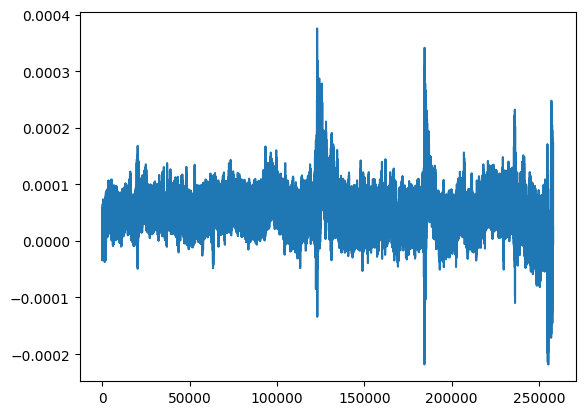

In [29]:
from matplotlib import pyplot as plt
plt.plot(raw[10,:][0].T)

In [30]:
# Step 1 Subtract 63 ms to account for EEG setup delay
raw.annotations.onset = raw.annotations.onset - 0.063


In [31]:
# Step 2 Re-sample the raw EEG data to 250 Hz
raw_resampled = raw.copy().resample(sfreq=250, npad="auto")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


/scratch/ipykernel_113170/3676571541.py:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=60)


Plotting power spectral density (dB=True).


/scratch/ipykernel_113170/3676571541.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered.plot_psd(fmax=60)


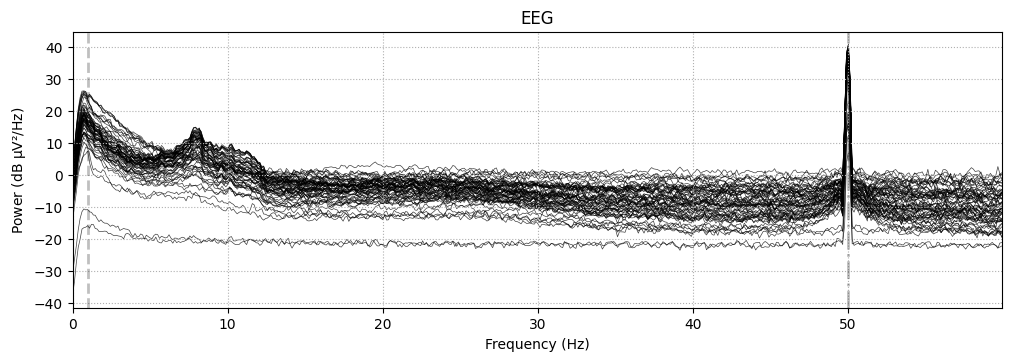

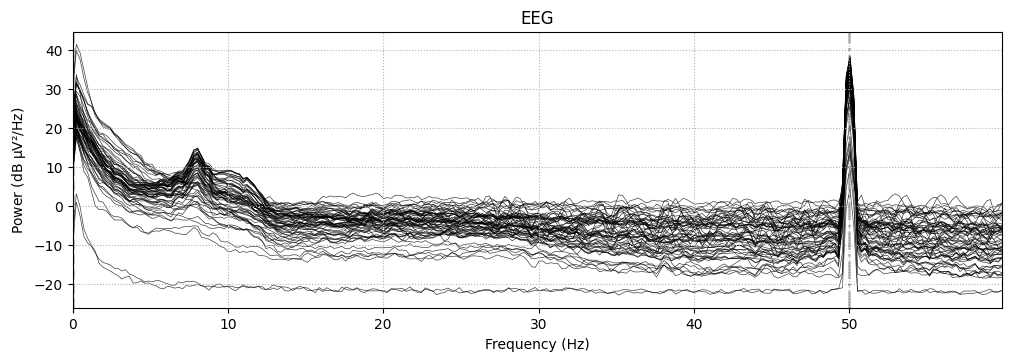

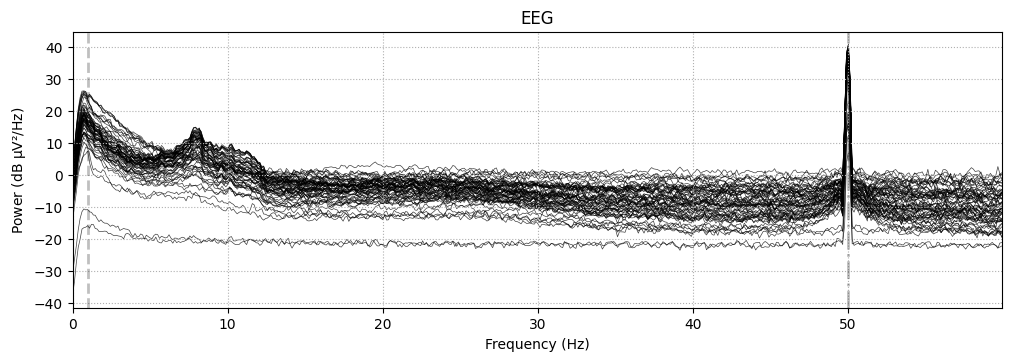

In [32]:
# Filtering 
# Step 3 High-pass filter at 1 Hz, low-pass filter at 125 Hz (at 124 cause of Nyquist)
filtered = raw_resampled.copy().filter(l_freq=1.0, h_freq=124.0)

# Plot the Power Spectral Density (PSD) before and after filtering
raw.plot_psd(fmax=60)  
filtered.plot_psd(fmax=60)  

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/scratch/ipykernel_113170/1471971579.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_filtered.plot_psd(fmax=60)


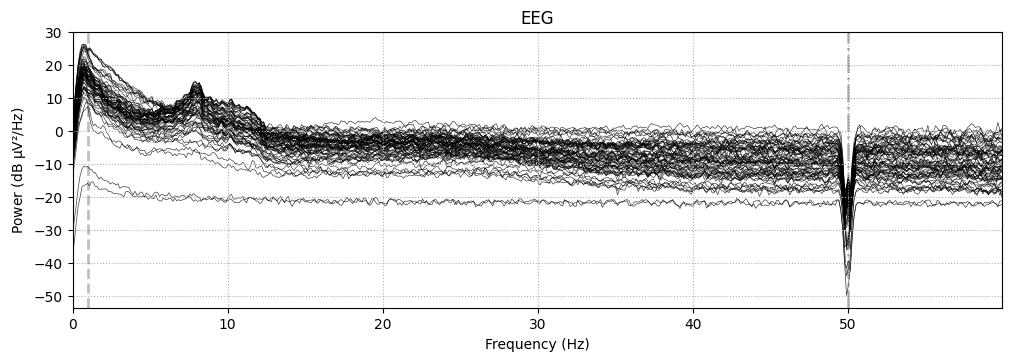

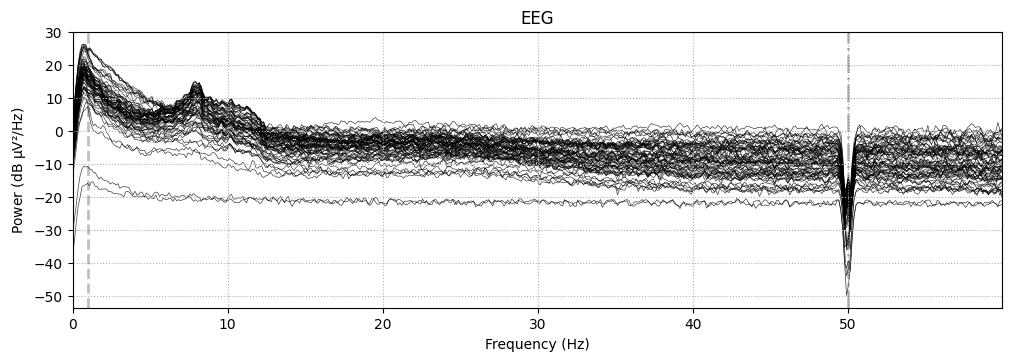

In [33]:
# Notch filter 50Hz to remove powerline artefact
raw_filtered = filtered.copy().notch_filter(freqs=50.0)
raw_filtered.plot_psd(fmax=60) 

Applying a custom ('EEG',) reference.


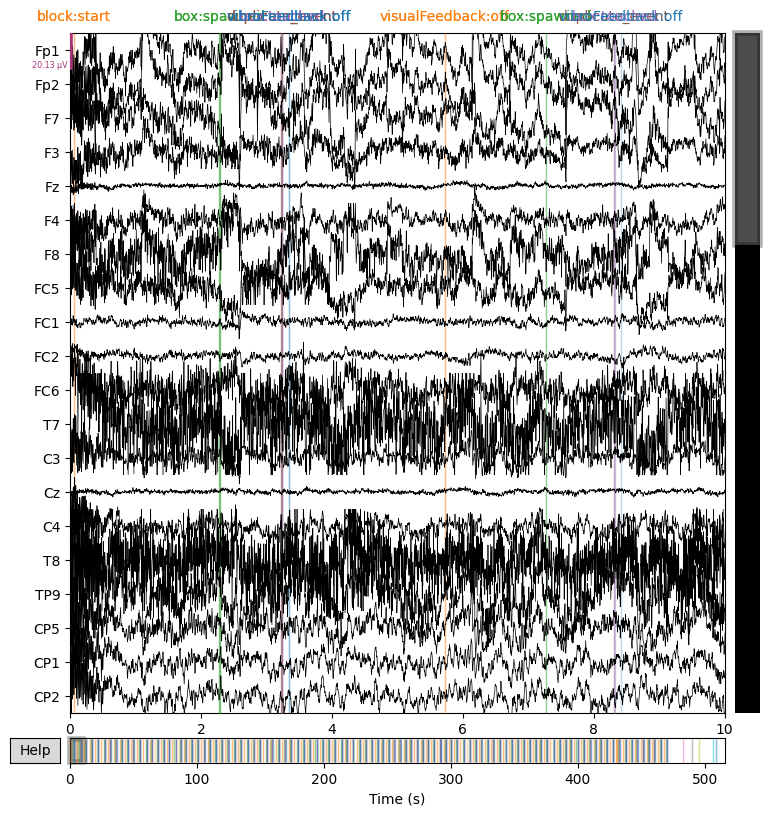

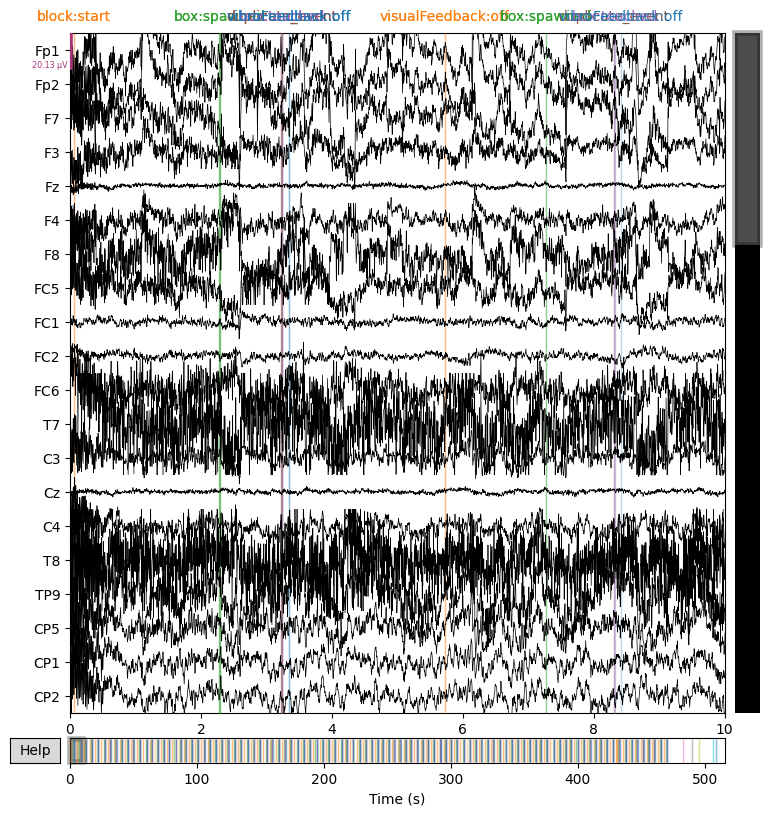

In [35]:
#Re-referencing to the clusters of frontal electrodes(Fz, FC1, FC2 and Cz)
raw_referenced = raw_filtered.set_eeg_reference(ref_channels=['Fz', 'FC1', 'FC2', 'Cz'], ch_type='eeg')
raw_referenced.plot(n_channels=20, scalings='auto', show=True, block=True)

Used Annotations descriptions: [np.str_('block:end'), np.str_('block:start'), np.str_('box:spawned'), np.str_('box:touched'), np.str_('duplicate_event'), np.str_('ipq_question_nr_1_answer:3'), np.str_('ipq_question_nr_2_answer:3'), np.str_('ipq_question_nr_3_answer:4'), np.str_('ipq_question_nr_4_answer:2'), np.str_('vibroFeedback:off'), np.str_('visualFeedback:off')]
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
505 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 505 events and 251 original time points ...
1 bad epochs dropped
Fitting ICA to data using 64 channels (please be patient, this may take a while)


/scratch/ipykernel_113170/197194423.py:22: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(selected_epochs)


Selecting by number: 10 components
Fitting ICA took 3.0s.


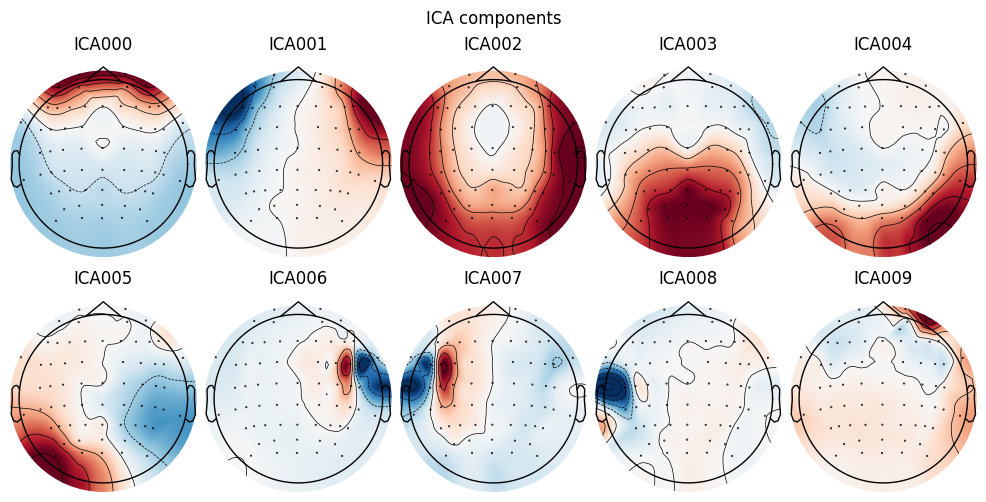

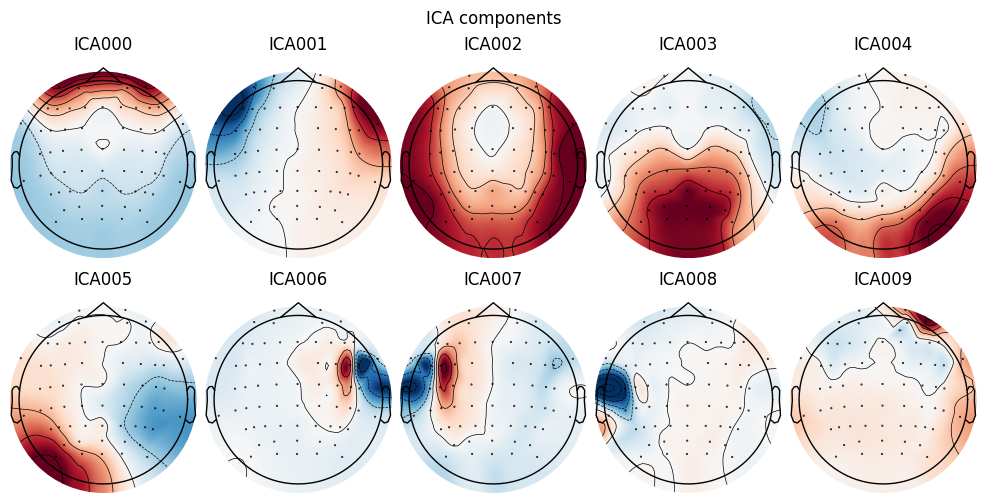

In [45]:
import numpy as np
import mne
from mne.preprocessing import ICA

# Assume `raw_referenced` is already preprocessed and loaded.

# Extract events and epochs
events, event_id = mne.events_from_annotations(raw_referenced)
epochs = mne.Epochs(raw_referenced, events, event_id, tmin=-0.3, tmax=0.7, 
                    preload=True, event_repeated="drop")

# Select 85% of the cleanest epochs
percentage = 85
n_epochs = len(epochs)
number_of_epochs_to_keep = int(n_epochs * (percentage / 100))

selected_indices = np.random.choice(range(n_epochs), size=number_of_epochs_to_keep, replace=False)
selected_epochs = epochs[selected_indices]

# Apply ICA
ica = ICA(n_components=10, method='picard', random_state=42, max_iter=5000)
ica.fit(selected_epochs)

# Plot ICA components
ica.plot_components()


In [42]:
raw_referenced.set_montage('standard_1020',match_case=False)
reconst_raw = raw_referenced.copy()
ica.fit(reconst_raw, method='picard')

raw_referenced.plot()
reconst_raw.plot() 

TypeError: fit() got an unexpected keyword argument 'method'